In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import math
import time
import random
import torch
import scipy.io
import torchvision
import numpy as np
import collections
import pandas as pd
import torch.nn as nn
import seaborn as sns
from PIL import Image
from fastai.basics import *
from fastai.vision import *
from sklearn import metrics
from matplotlib import pyplot as plt
from fastai.callbacks.hooks import *
import torch.utils.data as data_utils
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1. Read Data

In [0]:
dir = '/content/drive/My Drive/Masters/MSc Data Science University of Tartu/Computational NeuroScience Project/'
#/content/drive/My Drive/Masters/MSc Data Science University of Tartu/Computational NeuroScience Project/6845348
most_images_data = scipy.io.loadmat(dir + '6845348/natimg2800_M170714_MP032_2017-09-14.mat')
images_categories = scipy.io.loadmat(dir + '6845348/stimuli_class_assignment.mat')
images = scipy.io.loadmat(dir + '6845348/images_natimg2800_all.mat')['imgs']
### stimulus responses
resp = most_images_data['stim'][0]['resp'][0] # stimuli by neurons
istim = most_images_data['stim'][0]['istim'][0] # identities of stimuli in resp
cats = images_categories['class_assignment'][0] # cateogries of stimuli

In [4]:
images.shape

(68, 270, 2800)

In [5]:
len(cats)

2800

#### Get Images Labels / Categories
Total = 17 classes

17 classes from 0 to 16 ('unknown', 'birds', 'cats', 'flowers', 'hamsters', 'holes', 'insects', 'mice', 'mushrooms', 'nests', 'pellets', 'snakes', 'wildcats', 'other animals', 'other natural', 'other man made', 'grey').


In [0]:
labels_str = ['unknown', 'birds', 'cats', 'flowers', 'hamsters', 'holes', 'insects', 'mice', 'mushrooms', 'nests', 
             'pellets', 'snakes', 'wildcats', 'animals', 'natural', 'man_made', 'grey']

labels = np.zeros(len(istim))
for i in range(len(istim)):
    if istim[i] - 1 == 2800:
        labels[i] = 16 #gray image
    else:
        labels[i] = cats[istim[i] - 1]

([<matplotlib.axis.XTick at 0x7f12c7c2cbe0>,
 <a list of 17 Text xticklabel objects>)

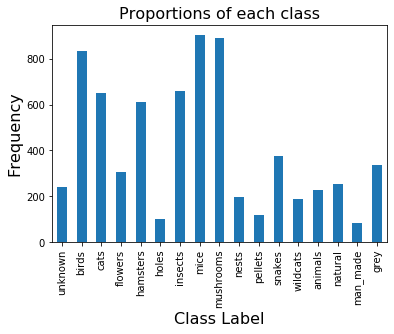

In [7]:
counter=collections.Counter(labels)
stars = pd.Series(labels)
vc = stars.value_counts().sort_index()
ax = vc.plot(kind='bar')
fig = ax.get_figure()
plt.title('Proportions of each class', fontsize = 16)
plt.xlabel('Class Label', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(np.arange(17), labels_str)

#### Convert data to pandas dataframes

In [0]:
X_data = pd.DataFrame(data = resp)
y_data = pd.DataFrame(data = labels)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=22)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# 2. Pretrained VGG19 and Fine Tune

In [0]:
#make batch size dimension to be the first dimension
images2 = np.transpose(images, (2, 0, 1))

In [10]:
#convert 1 channel to 3 channels
images2 = np.repeat(images2[:, np.newaxis, :, :], 3, axis=1)
#normalize by imagenet statistics
images2.astype('float64')
images2 = images2 / 255.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for i in range(3):
  images2[:, i, :, :] -= mean[i]
  images2[:, i, :, :] /= std[i]

images2.shape

(2800, 3, 68, 270)

##### Load Data into FastAI 

In [11]:
bs = 64
data_imgs = (ImageList.from_folder(dir + 'imgs_dataset')
              .split_by_folder(train='train', valid='valid')
              .label_from_folder()
              #.add_test_folder(dir + 'imgs_dataset/test/')
              .databunch(bs=bs)
              ).normalize(imagenet_stats)
# information about the batch
data_imgs.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (2240 items)
x: ImageList
Image (3, 68, 270),Image (3, 68, 270),Image (3, 68, 270),Image (3, 68, 270),Image (3, 68, 270)
y: CategoryList
9,9,9,9,9
Path: /content/drive/My Drive/Masters/MSc Data Science University of Tartu/Computational NeuroScience Project/imgs_dataset;

Valid: LabelList (560 items)
x: ImageList
Image (3, 68, 270),Image (3, 68, 270),Image (3, 68, 270),Image (3, 68, 270),Image (3, 68, 270)
y: CategoryList
14,14,14,14,14
Path: /content/drive/My Drive/Masters/MSc Data Science University of Tartu/Computational NeuroScience Project/imgs_dataset;

Test: None>

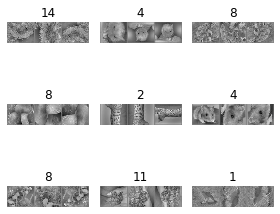

In [12]:
# take a look at the data
data_imgs.show_batch(rows=3, figsize=(4,4))

##### CE with Label Smoothing Class

In [0]:
class CELabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(CELabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

##### Call resnet34 Model and Fine Tune it.

In [0]:
metrics=[accuracy]
learner = cnn_learner(data_imgs, models.resnet34, pretrained = True,
                  loss_func= CELabelSmoothingLoss(16, smoothing = 0.1), 
                  #loss_func = nn.CrossEntropyLoss(),
                  metrics=metrics, opt_func=torch.optim.Adam)

In [0]:
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.save('before_finetune')

In [0]:
learner.unfreeze()

In [18]:
learner.fit_one_cycle(8, 1e-3)
learner.save('epochs8-lr_constant')

epoch,train_loss,valid_loss,accuracy,time
0,3.387251,2.537510,0.450000,06:31
1,2.620786,3.060857,0.403571,00:09
2,2.185001,1.853965,0.569643,00:09
3,1.719132,1.733612,0.635714,00:09
4,1.343654,1.431648,0.669643,00:09
5,1.101467,1.365403,0.733929,00:09
6,0.961068,1.333920,0.732143,00:09
7,0.886043,1.331861,0.725000,00:09


##### Feature Extraction

In [55]:
list(learner.model.modules())[-3]

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [0]:
images2 = torch.from_numpy(images2).float()

In [57]:
extracted_feats = {}
nn_module = list(learner.model.modules())[-3]
hook = hook_output(nn_module)
for i in range(len(images2)):
  learner.predict(images2[i])
  extracted_feats[i] = hook.stored[0]
  if i % 500 == 0:
    print('Finished:', i)

hook.remove

Finished: 0
Finished: 500
Finished: 1000
Finished: 1500
Finished: 2000
Finished: 2500


<bound method Hook.remove of <fastai.callbacks.hooks.Hook object at 0x7f12a3d064a8>>

# 3. Clustering Extracted Features

In [0]:
ext_feats = pd.DataFrame(extracted_feats).T

In [59]:
ext_feats.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,-0.603655,0.063424,0.069815,-0.362006,0.422147,-0.207205,-0.151701,-0.676102,-0.129107,-0.658876,-0.384182,-0.326348,-0.548655,0.460965,0.331828,-0.331413,-0.331608,-0.290639,-0.279476,-0.201360,-0.691653,1.124751,-0.048589,-0.749350,-0.179124,-0.694877,-0.252077,-0.227887,-0.421775,-0.290396,0.355985,0.342514,-0.737584,-0.628833,-0.287744,-0.753364,-0.327009,-0.730797,-0.710676,-0.228998,...,-0.409405,1.451805,-0.662406,-0.144003,0.045036,-0.698698,-0.351852,-0.239741,-0.842702,-0.242134,-0.29395,-0.299124,1.377860,-0.750475,-0.315767,0.844233,-0.342753,-0.611071,-0.678927,-0.721800,-0.237469,-0.322319,1.197522,-0.703418,-0.345385,2.411420,-0.246184,-0.143885,0.478208,-0.226212,0.222341,0.068064,-0.272300,-0.271860,-0.304261,-0.342517,-0.679586,-0.252209,-0.273235,-0.303249
1,-0.603655,0.575496,0.738282,-0.362006,0.079751,-0.207205,0.019364,-0.676102,-0.120797,-0.658876,-0.384182,-0.326348,-0.548655,0.160214,-0.118243,-0.331413,-0.331608,-0.290639,-0.279476,-0.201360,-0.691653,0.507792,0.895039,-0.594194,-0.232454,-0.244390,-0.252077,-0.227887,-0.182791,-0.290396,0.282599,0.428115,-0.737584,-0.628833,-0.287744,-0.753364,-0.327009,-0.390135,-0.710676,-0.228998,...,-0.770923,1.098404,-0.662406,-0.241123,-0.135141,0.345531,-0.351852,1.003719,-0.842702,-0.024605,-0.29395,-0.299124,0.575774,-0.750475,-0.315767,0.329164,-0.342753,-0.499109,-0.131802,0.178643,-0.237469,-0.322319,1.507677,-0.703418,-0.345385,2.284269,-0.246184,-0.286130,0.511204,0.044005,-0.031720,-0.001200,-0.272300,-0.109904,-0.395754,-0.342517,-0.679586,-0.252209,-0.273235,-0.303249
2,-0.603655,0.398725,0.630202,-0.362006,0.359671,-0.207205,-0.237349,-0.676102,0.302559,-0.658876,-0.384182,-0.326348,-0.548655,0.529961,0.081714,-0.331413,-0.331608,-0.290639,-0.279476,-0.201360,-0.691653,0.989212,0.221795,-0.749350,-0.232454,-0.270261,-0.252077,-0.227887,-0.168926,-0.290396,-0.214681,0.524152,-0.737584,-0.628833,-0.287744,-0.753364,-0.327009,-0.539864,-0.710676,-0.228998,...,-0.770923,0.872170,-0.662406,-0.241123,-0.242126,-0.697191,-0.351852,-0.034741,-0.842702,-0.225252,-0.29395,-0.299124,2.015857,-0.750475,-0.315767,0.459584,-0.342753,-0.393859,-0.678927,0.322163,-0.237469,-0.322319,1.679434,-0.703418,-0.345385,1.866717,-0.246184,-0.286130,0.398783,-0.204044,-0.023173,0.206557,-0.107707,-0.271860,-0.621948,-0.342517,-0.679586,-0.252209,-0.273235,-0.303249
3,-0.603655,0.543116,-0.155735,-0.362006,0.256584,-0.207205,-0.090370,-0.676102,0.228969,-0.658876,-0.384182,-0.326348,-0.548655,0.767449,-0.771716,-0.331413,-0.331608,-0.290639,-0.279476,-0.170047,-0.691653,1.267293,-0.491924,-0.749350,-0.232454,-0.551493,-0.242605,-0.227887,-0.421775,-0.290396,0.261987,0.403133,-0.737584,-0.628833,-0.271901,-0.753364,-0.327009,-0.069440,-0.710676,-0.228998,...,-0.770923,1.688532,-0.662406,-0.241123,-0.042160,-0.586170,-0.351852,0.461386,-0.842702,-0.082639,-0.29395,-0.299124,0.937135,-0.750475,-0.315767,0.478532,-0.342753,-0.646552,-0.678927,-0.491871,-0.237469,-0.322319,0.998318,-0.703418,-0.345385,3.307364,-0.246184,-0.286130,0.704435,0.045701,0.684148,0.252091,-0.272300,-0.016162,-0.614983,-0.342517,-0.679586,-0.252209,-0.273235,-0.303249
4,-0.603655,0.392159,-0.014310,-0.362006,0.340401,-0.207205,-0.080105,-0.676102,0.185445,-0.658876,-0.384182,-0.326348,-0.548655,0.563126,-0.449243,-0.331413,-0.331608,-0.290639,-0.279476,-0.196036,-0.691653,1.210904,0.305954,-0.749350,-0.232454,-0.450058,-0.235640,-0.227887,-0.064286,-0.290396,-0.180870,0.697134,-0.737584,-0.628833,-0.287744,-0.753364,-0.327009,0.925576,-0.710676,-0.228998,...,-0.770923,1.446674,-0.662406,-0.069849,-0.105512,-0.333286,-0.351852,0.544347,-0.842702,-0.105638,-0.28558,-0.299124,1.564002,-0.750475,-0.315767,0.476046,-0.342753,-0.671402,-0

In [0]:
norm_data = (ext_feats - ext_feats.mean()) / ext_feats.std()

In [72]:
# k means determine k
silhs = []
K = range(2,17)
for k in K:
    model = AgglomerativeClustering(n_clusters = k).fit(norm_data)
    cluster_labels = model.fit_predict(norm_data)
    silhs.append(silhouette_score(norm_data, cluster_labels))
    if k % 5 == 0:
      print('Finished: ', k)

Finished:  5
Finished:  10
Finished:  15


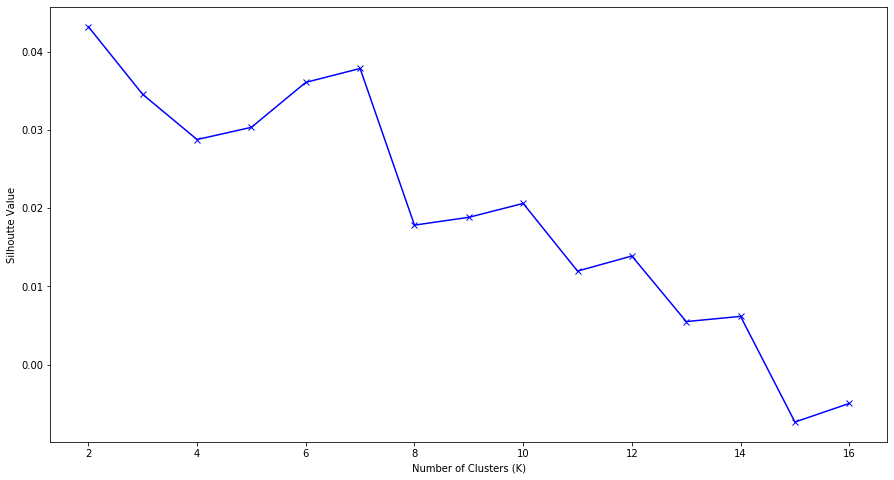

In [73]:
# Plot the elbow
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(K, silhs, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhoutte Value')
plt.show()

##### Use 7 clusters

In [0]:
model = AgglomerativeClustering(n_clusters = 7).fit(norm_data)

In [0]:
pred_labels = model.labels_

##### Check which classes are merged together

In [80]:
for i in range(7):
  print('Cluster #', i)
  counts = {}
  for j in range(16):
    counts[j] = 0
  for j in range(2800):
    if pred_labels[j] == i:
      counts[cats[j]] += 1
  for j in range(16):
    counts[j] = int(counts[j] / np.sum(cats == j) * 100 )
  print(counts, '\n###################################\n')

Cluster # 0
{0: 45, 1: 30, 2: 30, 3: 29, 4: 21, 5: 90, 6: 45, 7: 41, 8: 47, 9: 79, 10: 35, 11: 51, 12: 50, 13: 58, 14: 57, 15: 30} 
###################################

Cluster # 1
{0: 0, 1: 16, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0} 
###################################

Cluster # 2
{0: 13, 1: 5, 2: 24, 3: 5, 4: 63, 5: 2, 6: 2, 7: 26, 8: 5, 9: 1, 10: 3, 11: 10, 12: 6, 13: 7, 14: 5, 15: 8} 
###################################

Cluster # 3
{0: 17, 1: 8, 2: 12, 3: 39, 4: 3, 5: 4, 6: 24, 7: 12, 8: 39, 9: 9, 10: 45, 11: 16, 12: 23, 13: 17, 14: 22, 15: 36} 
###################################

Cluster # 4
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0} 
###################################

Cluster # 5
{0: 21, 1: 38, 2: 31, 3: 24, 4: 12, 5: 2, 6: 27, 7: 18, 8: 7, 9: 9, 10: 3, 11: 20, 12: 20, 13: 16, 14: 14, 15: 25} 
###################################

Cluster # 6
{0: 0, 1: 0, 2: 0, 3: 0,

##### Merging Labels
0, 5, 9, 11, 12, 13, 14 --> 0<br>
1, --> 1<br>
2, --> 2<br>
3, 8, 10, 15 --> 3 <br>
4, --> 4<br>
6, --> 5<br>
7, --> 6<br>



0: 'unknown', 
1: 'birds', 
2: 'cats', 
3: 'flowers', 
4: 'hamsters', 
5: 'holes', 
6: 'insects', 
7: 'mice', 
8: 'mushrooms', 
9: 'nests', 
10: 'pellets', 
11: 'snakes', 
12: 'wildcats', 
13: 'other animals', 
14: 'other natural', 
15: 'other man made'

In [0]:
conversion = {0:0, 1:1, 2:2, 3:3, 4:4, 5:0, 6:5, 7:6, 8:3, 9:0, 10:3, 11:0, 12:0, 13:0, 14:0, 15:3}
newcats = np.zeros(2800)

In [92]:
conversion[int(cats[0])]

1

In [0]:
for i in range(2800):
  #print(i, cats[0])
  newcats[i] = conversion[ int(cats[i]) ]

# 4. Normalize Image Responses by Average Grey Image Response

In [99]:
#Avg response of each image
X_data_avg = X_data.copy(deep = True)
X_data_avg['img_id'] = istim
X_avg = X_data_avg.groupby('img_id').mean().reset_index()
X_avg.tail()

,img_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,9436,9437,9438,9439,9440,9441,9442,9443,9444,9445,9446,9447,9448,9449,9450,9451,9452,9453,9454,9455,9456,9457,9458,9459,9460,9461,9462,9463,9464,9465,9466,9467,9468,9469,9470,9471,9472,9473,9474,9475
2796,2797,18.286285,5.475191,7.312119,17.661516,5.438449,8.502415,20.277079,1.458136,15.498446,17.667458,6.414128,2.656025,13.390599,49.641960,20.061636,10.989032,4.432568,75.067787,4.273264,10.855937,6.371981,23.838665,17.850824,37.503567,52.284111,3.865086,2.931680,30.176477,0.487072,63.103519,14.722604,24.814398,18.258017,41.035843,10.609184,65.992027,37.041653,8.148422,38.711586,...,6.332526,13.177214,20.959026,11.558198,10.400761,18.075226,29.966085,24.930056,72.869873,61.807064,46.675068,41.345131,61.443909,8.897824,8.019797,12.072711,16.815083,47.534122,3.129152,35.326588,28.193832,75.684425,44.804623,72.398048,21.200502,59.876457,13.413847,20.948425,7.364795,4.177186,6.899031,5.907485,16.486023,1.985680,0.000000,23.495197,6.977427,28.563713,53.257835,58.831486
2797,2798,13.418331,1.681373,9.097526,16.774158,5.912894,0.584047,34.769604,1.883367,0.352513,4.152332,6.465311,28.401834,4.504231,126.292847,21.707335,9.092346,4.128452,35.359291,18.577921,1.809870,12.654348,7.645593,0.000000,17.070166,4.174838,6.925031,23.326050,19.492481,1.401327,88.353264,23.407282,18.705313,34.669567,51.531666,51.652851,80.891029,16.013613,45.153347,26.366697,...,1.980921,3.952697,15.728487,6.716084,21.538774,17.771702,7.066660,12.280120,62.410488,10.954871,16.118242,13.724566,40.521664,46.091351,19.905983,4.500364,8.897869,105.549599,0.142466,35.361542,0.000000,208.007278,24.930990,48.215454,17.204626,30.230614,9.859921,20.924652,20.097599,23.472027,9.044582,1.541514,9.780148,6.382439,6.771379,0.000000,6.573892,190.322113,71.299530,7.149213
2798,2799,18.519575,5.151362,11.243047,6.723980,7.370479,1.251042,24.350960,0.000000,19.303417,99.678848,41.533146,19.070961,9.275496,21.638414,25.772013,3.991567,12.930327,25.002579,18.169996,48.097366,20.449574,31.347023,39.320869,15.123551,7.926655,8.938892,28.026348,6.186383,88.584663,123.155930,6.402894,1.315613,3.596293,169.346634,36.538815,40.918022,10.795135,275.121887,0.000000,...,1.305849,8.257910,122.641533,43.298141,0.000000,6.408874,0.032759,20.019947,66.573364,0.000000,33.630798,20.851412,0.000000,0.000000,17.611860,0.000000,44.621643,44.493504,0.000000,15.118766,1.500087,21.850918,23.175745,14.932175,29.290590,110.132126,32.536335,46.160828,45.463139,0.000000,7.847610,19.624817,10.488205,15.440705,19.819654,69.864975,2.791323,69.241829,12.354649,104.445007
2799,2800,5.024157,45.649441,166.623947,12.519175,1.972102,3.915522,22.461498,1.647021,1.769967,13.854001,16.921391,2.352147,13.636312,19.739946,11.797583,3.138170,3.959831,31.642195,9.368095,0.182042,39.685799,3.331670,6.569726,18.346050,20.964062,0.659753,28.874809,20.081999,0.000000,210.387070,15.854551,64.357880,64.163788,74.263947,34.860527,44.252129,9.498771,29.189768,21.686073,...,6.091959,23.648582,53.448704,32.862080,14.101669,41.365086,21.910141,33.752708,110.836258,0.000000,36.393173,27.908737,101.067886,20.446089,15.953091,20.626892,65.537697,22.896738,19.541071,93.863777,98.403580,34.648758,0.000000,23.877459,42.753677,86.510857,4.183181,15.891868,10.298369,23.137001,8.777534,5.105183,9.639045,45.332283,19.181452,39.594067,9.101516,60.633774,126.102570,250.542252
2800,2801,8.056371,4.486979,12.656736,9.146111,3.349355,3.508668,31.663065,2.843302,6.011918,11.862734,5.964007,9.958525,6.034552,59.084267,7.749821,4.620227,5.939221,4.612574,12.342426,7.245645,10.617437,6.404132,7.066882,15.226878,13.440695,7.263892,11.430602,21.826014,16.723806,68.411247,8.795705,6.083819,6.733058,47.203899,29.881153,25.758556,13.370513,14.190487,23.768204,...,6.653249,9.242069,13.907831,10.191943,15.353497,21.671907,13.374050,21.462494,40.474258,26.709137,32.922302,21.855959,55.633724,26.496044,14.847202,12.970654,17.350990,33.53517

In [0]:
X_avg_new = X_avg.div(X_avg.iloc[-1] + 1, axis='columns')
X_avg_new.drop(['img_id'], axis = 1, inplace = True)

X_norm = X_data.copy(deep = True)
X_avg.drop(['img_id'], axis = 1, inplace = True)
X_norm_new = X_norm.div(X_avg.iloc[-1] + 1, axis='columns')

##### New corresponding labels

In [0]:
new_labels = []
to_drop = []
for i in range(len(labels)):
  if labels[i] == 16:
    to_drop.append(i)
  else:
    new_labels.append(conversion[labels[i]])
X_norm_new.drop(to_drop, axis = 0, inplace = True)

In [162]:
X_norm_new.reset_index(drop=True, inplace=True)
X_norm_new.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9436,9437,9438,9439,9440,9441,9442,9443,9444,9445,9446,9447,9448,9449,9450,9451,9452,9453,9454,9455,9456,9457,9458,9459,9460,9461,9462,9463,9464,9465,9466,9467,9468,9469,9470,9471,9472,9473,9474,9475
6640,1.967876,2.895432,1.792556,0.000000,0.000000,1.606259,1.631553,0.000000,0.000000,0.989969,2.784296,1.037967,2.849811,0.325228,0.411712,1.408262,1.607885,0.000000,0.000000,0.000000,1.540220,2.406398,2.344793,0.853612,1.641610,0.075591,0.894991,1.022565,1.485397,0.749912,0.168849,0.253845,0.459802,2.846246,0.510196,0.267444,0.000000,4.399384,1.451783,1.154877,...,2.155480,0.000000,0.148436,2.127190,0.393687,2.475013,0.977533,1.064765,3.017698,6.975636,0.368865,0.822722,5.127421,0.000000,2.074211,1.362424,0.000000,1.228982,1.042809,0.000000,2.200358,0.486097,0.123407,0.018483,0.000000,0.997837,0.138259,0.120943,0.524682,1.955878,0.070027,0.000000,0.154813,1.464784,0.186550,0.879635,0.834388,0.950534,0.621967,0.016314
6641,0.000000,0.000000,0.000000,0.977941,4.865522,1.354944,0.171999,0.943874,0.000000,0.718078,1.241884,0.339491,0.000000,2.178928,0.489939,0.000000,0.000000,0.259347,0.000000,1.539050,0.000000,0.959810,2.203003,0.099865,0.314043,0.000000,0.933204,2.052907,1.347098,0.000000,0.000000,0.925419,0.000000,0.905263,0.000000,0.000000,0.381693,1.032971,0.391380,0.968136,...,0.000000,1.117130,0.000000,0.000000,5.322254,1.390343,1.140248,0.000000,0.922906,0.127332,0.616125,0.475662,2.327399,1.728735,0.000000,0.000000,0.541813,0.530623,3.410462,0.432420,0.000000,0.097571,1.444348,0.111069,0.000000,1.292960,0.393757,1.984865,0.000000,3.257585,1.293322,1.198010,0.400420,0.140850,0.682334,0.946089,0.892171,4.571561,2.583372,0.000000
6642,0.863451,0.000000,0.878810,0.827334,0.447520,0.000000,1.371075,0.000000,2.102959,0.596575,0.742212,0.000000,3.473693,0.133522,0.712910,0.907090,0.000000,4.111238,0.000000,1.275814,0.000000,1.193840,0.127696,0.083175,1.200471,0.651109,0.517698,0.899656,0.018310,0.302014,2.719362,1.228097,0.000000,0.000000,0.098370,0.000000,0.000000,7.440783,0.093423,0.491802,...,0.000000,1.341467,0.000000,1.008291,0.224250,0.000000,0.906665,1.604064,0.000000,0.000000,0.377914,0.142502,0.000000,0.225915,0.976551,2.586211,1.995505,2.509125,0.000000,1.374426,0.886603,0.813056,0.324235,0.534995,2.282433,1.056656,0.397992,0.000000,0.060067,0.075809,1.098004,1.757345,0.000000,0.243813,0.048187,0.000000,0.000000,1.882365,0.092123,0.427083
6643,0.910391,0.886099,0.328821,0.733530,1.449013,4.204736,1.364804,0.000000,8.614664,0.000000,0.000000,1.905829,2.182737,0.266908,2.417821,2.100399,0.000000,4.924129,1.480214,0.000000,0.587897,0.000000,0.000000,0.000000,2.537344,1.463175,0.000000,0.659708,1.724764,0.310346,0.367525,0.000000,5.758973,1.292820,0.593297,0.000000,0.097812,0.000000,0.660948,0.266886,...,1.560412,0.321080,2.578292,0.000000,11.407789,0.000000,0.708974,1.753436,0.457286,0.608154,0.000000,0.617247,0.085208,1.161770,0.000000,0.000000,0.575147,1.513751,2.612299,0.744603,0.000000,0.122198,1.105264,0.418692,1.355027,0.307142,0.629688,1.872846,2.126820,4.101775,3.126248,1.292725,0.580170,0.326016,0.202190,0.473293,1.830272,0.000000,1.612151,0.000000
6644,1.241531,0.420038,0.112621,0.000000,1.272270,0.587833,0.674957,0.000000,1.267974,0.000000,0.446475,1.621667,2.152695,0.221024,0.956331,0.492834,1.989469,7.517329,0.000000,0.246743,0.341314,0.982633,2.082594,0.273765,0.000000,0.000000,0.833084,0.333360,0.926221,0.532705,0.000000,1.832654,2.363598,0.554722,1.001618,0.886350,0.188202,6.904867,0.829391,0.000000,...,0.350110,0.202453,1.882784,1.097288,0.000000,2.385521,1.631879,1.623852,1.150437,0.648739,1.363457,2.282688,1.918728,0.000000,0.397986,1.775507,0.000000,1.106952,2.380229,0.248375,0.745195,1.902744,0.748407,0.247392,0.854323,0.595959,0.243377,3.701858,0.000000,1.632708,1.580705,2.071454,1.045341,1.047276,0.847836,0.919711,0.587496,0.108446,0.696117,0.174828


In [0]:
X_avg_new.drop(2800, axis = 0, inplace = True)

In [104]:
X_avg_new.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9436,9437,9438,9439,9440,9441,9442,9443,9444,9445,9446,9447,9448,9449,9450,9451,9452,9453,9454,9455,9456,9457,9458,9459,9460,9461,9462,9463,9464,9465,9466,9467,9468,9469,9470,9471,9472,9473,9474,9475
2795,0.000000,1.313945,0.368687,0.000000,1.062220,0.096670,1.146708,0.121059,2.089531,0.448634,0.179288,0.985236,1.767415,1.161859,2.068552,0.975746,0.477004,1.997542,0.178449,0.757404,0.987020,2.509067,0.060013,0.410451,0.441518,1.243584,3.748922,0.000000,0.366374,0.048885,2.339915,1.964041,1.662506,1.160160,1.329825,0.969141,0.870610,6.416043,0.755302,1.268114,...,1.544445,1.330800,0.000000,0.121128,0.251697,0.828500,0.936344,0.008070,1.656500,3.615577,0.797041,0.588733,1.162417,1.764508,3.986890,1.564067,0.946438,0.565505,0.000000,1.675459,0.788915,1.008563,0.542750,2.683050,2.355980,1.024502,0.381491,0.093543,0.571339,6.444159,1.911159,0.699367,1.612445,0.310560,0.305787,0.000000,0.871865,1.609219,1.733015,2.058376
2796,2.019163,0.997852,0.535422,1.740718,1.250403,1.885793,0.620795,0.379397,2.210300,1.373538,0.921040,0.242371,1.903547,0.826206,2.292805,1.955265,0.638770,13.374930,0.320276,1.316566,0.548484,3.219643,2.212853,2.311200,3.620609,0.467708,0.235844,1.322021,0.027481,0.909125,1.502965,3.502969,2.361034,0.851297,0.343549,2.466203,2.577615,0.536416,1.562955,1.029952,...,0.827430,1.286577,1.405907,1.032725,0.635996,0.797252,2.084735,1.109853,1.756990,2.230566,1.375940,1.808943,1.084935,0.323604,0.506070,0.864148,0.916304,1.376397,0.284745,0.971978,0.963229,1.791654,2.095694,2.668652,0.930163,1.159850,1.283205,0.933091,0.431634,0.560812,0.703693,0.646587,1.524384,0.091919,0.000000,1.504984,0.413419,0.899323,1.291785,0.587914
2797,1.481645,0.306430,0.666157,1.653260,1.359487,0.129539,1.064493,0.490039,0.050273,0.322819,0.928389,2.591757,0.640301,2.101929,2.480889,1.617790,0.594945,6.300013,1.392395,0.219494,1.089255,1.032612,0.000000,1.051968,0.289102,0.837987,1.876502,0.853959,0.079065,1.272895,2.389545,2.640569,4.483294,1.069035,1.672634,3.022997,1.114338,2.972475,1.064538,0.875409,...,0.258834,0.385928,1.055049,0.600082,1.317075,0.783864,0.491626,0.546694,1.504801,0.395352,0.475152,0.600481,0.715504,1.676290,1.256120,0.322130,0.484871,3.056293,0.012964,0.972939,0.000000,4.924093,1.166124,1.777261,0.754846,0.585589,0.943227,0.932032,1.177876,3.151258,0.922537,0.168722,0.904323,0.295450,0.565026,0.000000,0.389509,5.992257,1.729392,0.071443
2798,2.044922,0.938834,0.823260,0.662715,1.694614,0.277475,0.745520,0.000000,2.752944,7.749429,5.963972,1.740285,1.318562,0.360134,2.945433,0.710215,1.863369,4.454744,1.361821,5.833063,1.760248,4.233720,4.874358,0.932006,0.548911,1.081681,2.254625,0.271023,4.998061,1.774294,0.653643,0.185721,0.465054,3.513131,1.183208,1.529157,0.751200,18.111460,0.000000,0.000000,...,0.170627,0.806274,8.226651,3.868689,0.000000,0.282679,0.002279,0.891261,1.605173,0.000000,0.991407,0.912297,0.000000,0.000000,1.111355,0.000000,2.431566,1.288353,0.000000,0.415978,0.051250,0.517270,1.084024,0.550412,1.285112,2.133339,3.112514,2.056109,2.664495,0.000000,0.800447,2.147979,0.969794,0.714768,1.653816,4.475199,0.165389,2.180066,0.299666,1.043738
2799,0.554765,8.319595,12.200861,1.233889,0.453424,0.868443,0.687673,0.428543,0.252423,1.077065,2.429835,0.214641,1.938476,0.328538,1.348323,0.558371,0.570645,5.637733,0.702128,0.022077,3.416054,0.449974,0.814407,1.130596,1.451735,0.079836,2.322881,0.879786,0.000000,3.031023,1.618521,9.085195,8.297337,1.540621,1.128861,1.653756,0.660990,1.921582,0.875561,3.161824,...,0.795996,2.308965,3.585277,2.936226,0.862303,1.824508,1.524284,1.502625,2.672411,0.000000,1.072839,1.221071,1.784588,0.743601,1.006682,1.476444,3.571344,0.662998,1.778186,2.582573,3.361912,0.820229,0.000000,0.880143,1.875799,1.675778,0.400174,0.707860,0.603565,3.106279,0.895298,0.558773,0.891276,2.098484,1.600562,2.536197,0.539274,1.909043,3.058656,2.503713


##### Split into Train and Validation

In [0]:
X_data2 = pd.DataFrame(data = X_norm_new)
y_data2 = pd.DataFrame(data = new_labels)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_data2, y_data2, list(range(6645)), test_size=0.2, random_state=22)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [164]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9436,9437,9438,9439,9440,9441,9442,9443,9444,9445,9446,9447,9448,9449,9450,9451,9452,9453,9454,9455,9456,9457,9458,9459,9460,9461,9462,9463,9464,9465,9466,9467,9468,9469,9470,9471,9472,9473,9474,9475
4051,1.942199,1.300784,1.779249,2.665829,0.448335,2.448481,2.024593,1.573514,2.455836,2.805307,0.000000,0.633608,4.331805,1.565957,1.163792,1.736386,3.292489,0.000000,0.000000,0.000000,0.000000,4.603966,0.000000,0.473167,0.000000,1.122608,1.101200,0.831223,1.659908,3.152014,2.081890,2.979847,14.170751,2.199776,0.221119,1.968834,0.880507,8.139701,0.325500,0.636640,...,0.117076,0.000000,0.000000,0.000000,4.037182,0.742131,6.462683,2.837810,0.861690,0.000000,0.976636,1.392503,0.387118,0.000000,2.714326,1.664353,0.608968,1.186105,2.656577,0.972090,0.692838,1.389446,0.353390,0.548557,1.057718,0.035578,3.081783,1.537564,0.000000,0.000000,0.190740,0.000000,0.048497,2.549395,0.701741,0.191900,0.025594,1.757022,0.000000,0.000000
4179,0.000000,0.000000,1.238061,1.413546,0.915202,1.349980,1.075717,1.630497,0.000000,0.838777,1.399642,0.000000,7.671698,0.000000,2.816288,0.000000,0.937990,11.245267,0.000000,0.000000,0.925463,1.204427,0.000000,2.270792,1.325743,0.000000,21.382275,0.686729,0.754018,0.902907,0.707700,3.354656,0.514939,0.000000,6.747681,0.000000,1.629006,44.696980,1.614609,0.642411,...,1.429873,3.795983,1.198740,0.526784,2.282468,1.518264,4.101302,0.545570,0.647145,0.000000,1.068786,2.383745,0.000000,0.098860,1.725093,1.014599,0.000000,2.110917,0.877954,0.000000,1.805817,2.490381,2.600151,1.538828,1.283818,1.202860,0.978795,0.000000,0.000000,2.943477,0.912105,1.353965,0.000000,1.292004,2.521075,5.518864,2.540383,0.000000,1.386106,0.229826
2028,11.432014,1.628272,0.661866,0.000000,0.000000,0.093464,0.000000,0.000000,0.565100,0.000000,3.737879,0.000000,2.839217,0.830322,0.000000,3.181842,1.295011,3.965576,13.296950,1.308424,1.542457,0.989137,1.697234,2.460434,6.025136,0.000000,2.008021,0.949010,0.560437,0.000000,0.900273,2.623821,0.000000,0.518218,3.339982,1.513204,0.000000,0.839983,0.741930,0.381160,...,0.000000,0.000000,1.087939,0.050623,0.000000,0.181081,2.387179,0.000000,0.666101,0.401281,3.119969,1.418918,0.000000,0.164629,0.000000,0.299553,0.770098,4.228849,0.000000,0.000000,2.220587,0.936220,0.000000,0.251803,5.301139,0.000000,1.614760,0.000000,0.000000,3.225336,0.000000,0.111903,1.462306,1.091611,1.410741,3.077363,0.383399,0.723129,0.000000,0.000000
292,0.000000,0.000000,0.971858,0.665150,0.795671,5.482308,0.124823,2.097348,0.000000,0.000000,11.168728,0.132363,1.113325,0.217294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.370228,5.574747,3.129033,0.000000,0.395684,2.423926,0.000000,0.188714,2.119485,0.000000,0.847702,5.712704,0.000000,2.620793,0.000000,0.292322,0.000000,6.747923,0.439982,0.443970,...,0.543436,2.770725,1.454743,4.550073,0.000000,1.112387,0.000000,1.780040,0.000000,0.517527,1.332718,1.105536,0.000000,1.985162,0.885554,0.000000,0.000000,0.000000,3.148922,0.668387,0.396249,1.328532,0.280118,0.150829,3.952699,1.811227,2.322823,0.000000,1.219123,2.705213,1.085523,2.430465,0.000000,0.879041,0.000000,2.386487,1.214042,12.932995,3.239090,0.827006
4325,4.629938,3.756505,1.923135,2.217661,0.926981,1.385573,0.502377,0.000000,0.108698,2.467043,1.171751,14.179666,7.200455,0.763294,0.000000,0.584156,0.168524,0.000000,0.195582,2.753742,0.000000,1.707198,2.388389,0.000000,0.000000,2.596283,2.776906,0.115467,13.313705,2.204343,0.000000,3.370439,60.032082,4.467082,0.000000,1.866534,0.000000,15.474875,1.141113,0.778919,...,3.915198,0.498630,3.017395,1.351530,4.200128,0.020567,0.000000,1.939582,2.195544,2.081003,0.269037,3.178033,2.267489,0.550892,1.900726,0.000000,0.505316,0.605956,3.373746,0.000000,1.341386,0.000000,3.377022,2.265069,0.230878,1.474270,0.660804,2.550645,2.290793,4.114798,1.695598,0.422048,0.000000,4.798410,0.000000,2.468047,0.000000,1.274755,0.659739,1.557322


# 5. Fit Model

In [0]:
X_data2['class'] = new_labels

In [0]:
cont_names = list(X_data2.columns.values[:-1])

In [0]:
from fastai.tabular import *
tabular_data = (TabularList.from_df(X_data2, cont_names = cont_names)
        .split_by_idx(valid_idx = indices_test)
        .label_from_df(cols = 'class')
        .databunch())

In [0]:
learn = tabular_learner(tabular_data, layers=[5000, 2048, 128], metrics=accuracy, 
                        loss_func= CELabelSmoothingLoss(7, smoothing = 0.1), 
                        opt_func=torch.optim.Adam)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


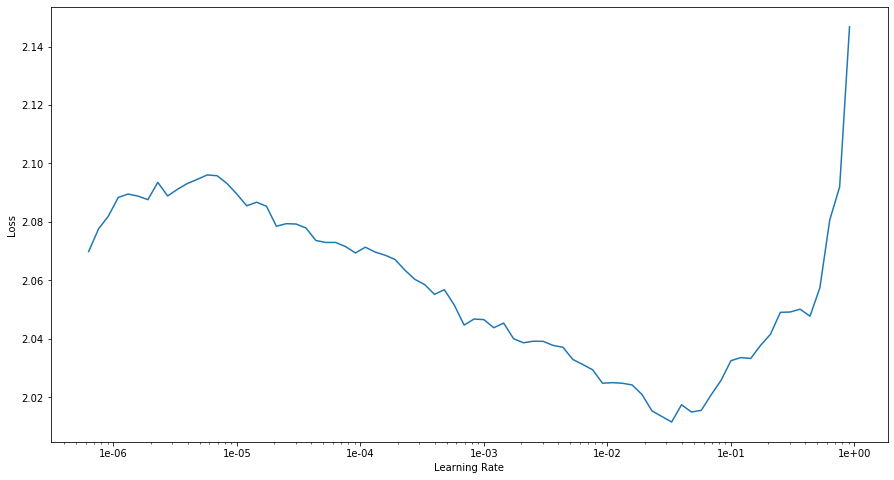

In [212]:
learn.lr_find()
learn.recorder.plot()

In [213]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.907916,1.856333,0.303236,00:05
1,1.303720,2.197582,0.274643,00:05
2,1.083256,2.113641,0.311512,00:05
3,0.742325,2.054985,0.334086,00:05
4,0.592455,1.926523,0.342363,00:05
5,0.543427,1.900461,0.346125,00:05
6,0.526480,1.890727,0.355154,00:05
7,0.519649,1.869312,0.344620,00:05
8,0.517575,1.886430,0.358164,00:05
9,0.517622,1.876976,0.350640,00:05
